In [1]:
#The purpose of this is to use an exon centric analysis:
#Take all exons and label as constitutive vs spliced 
#Associate exons with iCLIP binding to get the total

In [2]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
from math import *
from subprocess import *
import pybedtools as pbt
from glob import glob
import seaborn as sns
import statsmodels.formula.api as sm
import csv
import re
import scipy.stats as ss
csv.register_dialect("textdialect",delimiter='\t')
%matplotlib inline
mpl.rc("lines", markeredgewidth=0.5)



/home/sam/anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [3]:
#datasets to use for RT stops = mega dataframe_gene_expression_normalized_1nt
#this one has all of the information and is also normalized with gene calls to the highest expression in a given sample
clip_df = pd.read_csv('hnM_DMSO_TAM_master_dataframe_gene_expression_normalized_1nt',sep='\t')

In [4]:
clip_df.head()

,cluster_id,chrom,start,end,ens_gene,blank,strand,hnM_DMSO,hnM_TAM,hnM_DMSO_1,...,external_gene_name,biotype,twist_d0_fpkm_1,twist_d14_fpkm_1,log2ratio_fpkm_d14_d0,hnM_DMSO_clip_gene_fpkm_norm,hnM_TAM_clip_gene_fpkm_norm,hnM_DMSO_clip_gene_fpkm_norm_1,hnM_TAM_clip_gene_fpkm_norm_1,log2ratio_hnM_TAM_DMSO_clip_gene_fpkm_norm
0,chr1:251639-251640,chr1,251639,251640,ENSG00000228463,0,-,6.521757,0.000000,7.521757,...,AP006222.2,lincRNA,1.040763,1.117389,0.102490,6.266323,0.000000,7.266323,1.000000,-2.861225
1,chr1:251646-251647,chr1,251646,251647,ENSG00000228463,0,-,2.898558,0.000000,3.898558,...,AP006222.2,lincRNA,1.040763,1.117389,0.102490,2.785032,0.000000,3.785032,1.000000,-1.920306
2,chr1:564514-564515,chr1,564514,564515,ENSG00000225972,0,+,0.000000,5.691002,1.000000,...,MTND1P23,unprocessed_pseudogene,9.666940,27.279600,1.496691,0.000000,0.208618,1.000000,1.208618,0.273358
3,chr1:564595-564596,chr1,564595,564596,ENSG00000225972,0,+,5.072477,0.000000,6.072477,...,MTND1P23,unprocessed_pseudogene,9.666940,27.279600,1.496691,0.524724,0.000000,1.524724,1.000000,-0.608548
4,chr1:564722-564723,chr1,564722,564723,ENSG00000225972,0,+,0.000000,19.349407,1.000000,...,MTND1P23,unprocessed_pseudogene,9.666940,27.279600,1.496691,0.000000,0.709300,1.000000,1.709300,0.773405


In [5]:
clip_df.columns.tolist()

['cluster_id',
 'chrom',
 'start',
 'end',
 'ens_gene',
 'blank',
 'strand',
 'hnM_DMSO',
 'hnM_TAM',
 'hnM_DMSO_1',
 'hnM_TAM_1',
 'log2ratio_TAM-DMSO',
 'gene',
 'gene_coords',
 'twist_d0_fpkm',
 'twist_d14_fpkm',
 'twist_d0_d14_fpkm_sum',
 'twist_d0_tpm',
 'twist_d14_tpm',
 'chr',
 'coords',
 'gene_length',
 'external_gene_name',
 'biotype',
 'twist_d0_fpkm_1',
 'twist_d14_fpkm_1',
 'log2ratio_fpkm_d14_d0',
 'hnM_DMSO_clip_gene_fpkm_norm',
 'hnM_TAM_clip_gene_fpkm_norm',
 'hnM_DMSO_clip_gene_fpkm_norm_1',
 'hnM_TAM_clip_gene_fpkm_norm_1',
 'log2ratio_hnM_TAM_DMSO_clip_gene_fpkm_norm']

In [6]:
#Splicing library
#Description of ucsc known alt
# This track shows various types of alternative splicing and other events that result in more than a single transcript from the same gene. The label by an item describes the type of event. The events are:

# Alternate Promoter (altPromoter) - Transcription starts at multiple places. The altPromoter extends from 100 bases before to 50 bases after transcription start.
# Alternate Finish Site (altFinish) - Transcription ends at multiple places.
# Cassette Exon (cassetteExon) - Exon is present in some transcripts but not others. These are found by looking for exons that overlap an intron in the same transcript.
# Retained Intron (retainedIntron) - Introns are spliced out in some transcripts but not others. In some cases, particularly when the intron is near the 3' end, this can reflect an incompletely processed transcript rather than a true alt-splicing event.
# Overlapping Exon (bleedingExon) - Initial or terminal exons overlap in an intron in another transcript. These often are associated with incompletely processed transcripts.
# Alternate 3' End (altThreePrime) - Variations on the 3' end of an intron.
# Alternate 5' End (altFivePrime) - Variations on the 5' end of an intron.
# Intron Ends have AT/AC (atacIntron) - An intron with AT/AC ends rather than the usual GT/AG. These are associated with the minor spliceosome.
# Strange Intron Ends (strangeSplice) - An intron with ends that are not GT/AG, GC/AG, or AT/AC. These are usually artifacts of some sort due to sequencing error or polymorphism

#rmats splicing library
def getASEvents(asDir,): ## get AS events from GTF and SAM files
    logging.debug("getting AS events function..");

    samNames1=uniqSamNames(1);
    samNames2=uniqSamNames(2);
    finalSamNames = ','.join(samNames1)+','+','.join(samNames2);  
    if lite==1:
        finalSamNames = ','.join(samNames1); ## for the lite version

    #cmd = 'python '+binPath+'/processGTF.SAMs.py '+gtf+' '+asDir+'/fromGTF'+' '+finalSamNames+' '+libType+' '+tempPath;
    cmd = 'python '+binPath+'/processGTF.BAMs.py '+gtf+' '+asDir+'/fromGTF'+' '+finalSamNames+' '+libType+' '+SEPE+' '+str(novelSS) +' '+tempPath;
    #oFile.write('###### getting AS events from GTF and SAM files #####\n'+cmd+'\n#\n');
    oFile.write('###### getting AS events from GTF and BAM files #####\n'+cmd+'\n#\n');
    oFile.flush();
    status,output=commands.getstatusoutput(cmd);
    logging.debug("getting AS events is done with status %s" % status);
    if (int(status)!=0): ## it did not go well
        logging.debug("error in getting AS events %s" % status);
        logging.debug("error detail: %s" % output);
    raise Exception();
    logging.debug(output);

In [7]:
#add an id to each exon
with open('spliced_exon_analysis/hg19_v19_exons.bed') as f:
    counter = 1
    outlist = []
    for line in f:
        line = line.strip().split('\t')
        line[4] = "exon_"+str(counter)
        counter += 1
        outlist.append(line)
with open('spliced_exon_analysis/hg19_v19_exons_with_exon_id.bed','w') as f:
    writer = csv.writer(f,'textdialect')
    writer.writerows(outlist)

In [8]:
%%time
#first step collect exons and associate with features
hg19_v19_exons = pd.read_csv('spliced_exon_analysis/hg19_v19_exons_with_exon_id.bed',sep='\t',names=['chrom','start','stop','ens_gene','exon_id','strand'])
#remove gene name stuff after ens_gene
hg19_v19_exons['ens_gene']=hg19_v19_exons.ens_gene.str.split('.').str[0]    
#read in gene names and biotypes
#I got this from ensembl biomart using the last GRCh37 archive - ENS version 75
hg19_grch37_gene_names_and_biotype = pd.read_csv('spliced_exon_analysis/ensembl_ens_gene_gene_name_biotype_grch37_p13',sep='\t',names=['ens_gene','external_gene_name','biotype'])
#why are there duplicates?
hg19_grch37_gene_names_and_biotype.drop_duplicates(inplace=True)

#merge the exons with the gene names and biotypes
hg19_v19_exons = pd.merge(hg19_v19_exons,hg19_grch37_gene_names_and_biotype,on='ens_gene',how='left')
hg19_v19_exons.to_csv('spliced_exon_analysis/hg19_v19_exon_gene_names_and_biotypes',sep='\t',header=False,index=False,na_rep='NaN')

#create a bedtools
hg19_v19_exons_bt = pbt.BedTool.from_dataframe(hg19_v19_exons,na_rep='NaN')


CPU times: user 2.24 s, sys: 48 ms, total: 2.29 s
Wall time: 2.31 s


In [18]:
%%time

#now I need to bring in the library of splice exons
#Lets try multiple sources - first use hg38 known alt
#first - hg38 known alt but lifted to hg19 - this has many more events - roughly double the number of cassette exons
#could also try the regular hg19 in case there are too many spliced exons
known_alt = pd.read_csv('/media/sam/Data1/annotations/splicing_libraries/knownAlt_hg19.bed',sep='\t',names=['chrom','start','end','splicing_type','score','strand'])
known_alt_bt = pbt.BedTool.from_dataframe(known_alt)
known_alt_cassette = known_alt[known_alt.splicing_type == "cassetteExon"]
known_alt_cassette_bt = pbt.BedTool.from_dataframe(known_alt_cassette).sort()

#intersect all of known alt with the hg19_v19_exons to find those that don't intersect with any known splicing event and are thus constitutive. also collect those that are alternative
hg19_v19_constitutive_exons = hg19_v19_exons_bt.intersect(b=known_alt_bt,s=True,v=True,wa=True)
hg19_v19_alternative_exons = hg19_v19_exons_bt.intersect(b=known_alt_bt,s=True,u=True,wa=True)
print((float(len(hg19_v19_alternative_exons))/float(len(hg19_v19_exons_bt))*100),'percent of exons are alternative')

#now figure out which alternative exons are cassette exons. intersect alternative with cassette 
#should i require a fraction of overlap? 
#should I require there be a perfect match or a partial match? Here I require a perfect reciprocal match
hg19_v19_alternative_cassette_exons = hg19_v19_alternative_exons.intersect(b=known_alt_cassette_bt,wa=True,s=True,u=True,f=1.0,r=True)
hg19_v19_alternative_non_cassette_exons = hg19_v19_alternative_exons.intersect(b=known_alt_cassette_bt,wa=True,s=True,v=True,f=1.0,r=True)

#focus on cassette exons to start
#in the dataframe label exons as alternative or not alternative and then cassette or non-cassette
header = ['chrom','start','end','ens_gene','exon_id','strand','external_gene_name','biotype']
hg19_v19_alternative_cassette_exons_df = hg19_v19_alternative_cassette_exons.to_dataframe(names=header)
hg19_v19_alternative_cassette_exons_df['alternative'] = 'yes'
hg19_v19_alternative_cassette_exons_df['splicing_type'] = 'cassette'

hg19_v19_alternative_non_cassette_exons_df = hg19_v19_alternative_non_cassette_exons.to_dataframe(names=header)
hg19_v19_alternative_non_cassette_exons_df['alternative'] = 'yes'
hg19_v19_alternative_non_cassette_exons_df['splicing_type'] = 'other'

hg19_v19_constitutive_exons_df = hg19_v19_constitutive_exons.to_dataframe(names=header)
hg19_v19_constitutive_exons_df['alternative'] = 'no'
hg19_v19_constitutive_exons_df['splicing_type'] = 'constitutive'

hg19_v19_exons_labeled_df = pd.concat([hg19_v19_alternative_cassette_exons_df,hg19_v19_alternative_non_cassette_exons_df,hg19_v19_constitutive_exons_df],ignore_index=True)
hg19_v19_exons_labeled_df.to_csv('spliced_exon_analysis/hg19_v19_exons_labeled_as_alternatively_spliced',sep='\t',index=False)

#bring back go bedtool
hg19_v19_exons_labeled_bt = pbt.BedTool.from_dataframe(hg19_v19_exons_labeled_df,na_rep='NaN')
hg19_v19_exons_labeled_bt_sorted = hg19_v19_exons_labeled_bt.sort()
hg19_v19_exons_labeled_bt_sorted.saveas('hg19_v19_exons_labeled_bt_sorted')

(18.167386921972, 'percent of exons are alternative')
CPU times: user 4.23 s, sys: 260 ms, total: 4.49 s
Wall time: 7.21 s


In [21]:
known_alt_cassette.head()

,chrom,start,end,splicing_type,score,strand
26,chr1,14969,15038,cassetteExon,0,-
33,chr1,17232,17368,cassetteExon,0,-
35,chr1,17258,17368,cassetteExon,0,-
37,chr1,17605,17742,cassetteExon,0,-
41,chr1,18267,18379,cassetteExon,0,-


In [20]:
#Something to note here:
#the total number of known_alt_cassette exons does not match the total number of hg19_v19_alternative_cassette_exons. I required that the hg19_known_alt match perfectly and reciprocally with the hg19_v19_exons

#This seems too large... I should try to filter this by what is actually expressed in the cell in terms of the transcript. But this could be a problem if we are looking for things associated with non-sense mediated decay
print(len(known_alt_cassette))
print(len(hg19_v19_alternative_cassette_exons))

31745
20911


In [14]:
#collect a dataframe of the RT stops for each sample
#I have the clip DF, which has the gene expression normalized value. Remember this is normalized binding for library divided by FPKM + 1. I will use this value for assigning binding. No need for length normalization at this point.
clip_normalized_binding_names = ['chrom','start','end','ens_gene','blank','strand','hnM_DMSO_clip_gene_fpkm_norm','hnM_TAM_clip_gene_fpkm_norm']
clip_normalized_binding_df = clip_df[clip_normalized_binding_names]
#for RT stops without gene expression correlate, just throw away by setting na_rep = 0
clip_normalized_binding_bt = pbt.BedTool.from_dataframe(clip_normalized_binding_df,na_rep=0.0)
# clip_normalized_binding_bt.saveas('clip_normalized_binding_bt')

In [15]:
#Now - I need to take the exons and associate with binding. 
#Strategy - I have the exons. Now I need to sum the binding within x nucleotides of the exon and see if it is higher for spliced vs non spliced exons on average. Make a boxplot.
#Tools - use bedtools intersect and then bedtools merge while summing

#Note, because of different exon size, I need to normalize the binding value based on total interval length. Just divide by the interval length at the end

#Another solution would be to just use intronic RT stops, but even then, if there are variable splice sites, some "intronic" reads will be considered exonic.

#slop the exons with a given interval. 
slop_length = 300
hg19_v19_exons_labeled_bt_sorted_slop = hg19_v19_exons_labeled_bt_sorted.slop(genome="hg19",b=slop_length)


#Intersect the slopped exons with the binding data
hg19_v19_exons_labeled_bt_sorted_clip_slop_intersect = hg19_v19_exons_labeled_bt_sorted_slop.intersect(b=clip_normalized_binding_bt,s=True,wa=True,wb=True,sorted=True)

#Groupby and sum the proper columns - this is much better than merge - i should have thought of this
hg19_v19_exons_labeled_bt_sorted_clip_slop_intersect_grouped = hg19_v19_exons_labeled_bt_sorted_clip_slop_intersect.groupby(g=[1,2,3,4,5,6,7,8,9,10],c=[17,18],o=["sum","sum"])

#Now I need to import into pandas for more work and boxplots
header = ['chrom','start','end','ens_gene','exon_id','strand','external_gene_name','biotype','alternative','splicing_type','hnM_DMSO_clip_fpkm_norm','hnM_TAM_clip_fpkm_norm']
intersect_df = hg19_v19_exons_labeled_bt_sorted_clip_slop_intersect_grouped.to_dataframe(names=header)

#add a column for length
intersect_df['interval_length'] = intersect_df.end.astype('float')-intersect_df.start.astype('float')

#calculate length normalized binding
intersect_df['hnM_DMSO_clip_fpkm_length_norm'] = intersect_df.hnM_DMSO_clip_fpkm_norm / intersect_df.interval_length
intersect_df['hnM_TAM_clip_fpkm_length_norm'] = intersect_df.hnM_TAM_clip_fpkm_norm / intersect_df.interval_length

#save the intersect_df
intersect_df.to_csv('spliced_exon_analysis/hg19_v19_exons_labeled_hnRNPM_clip_intersect',sep='\t',index=False)

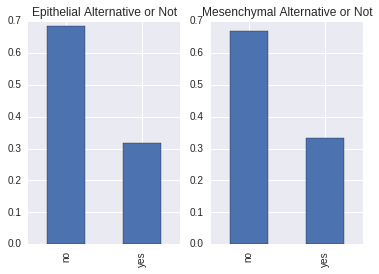

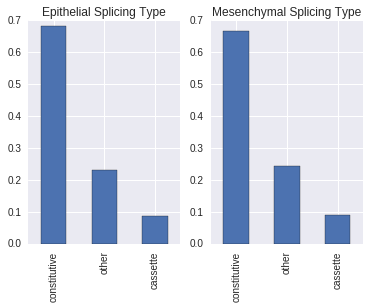

In [38]:
#Now lets groupby and plot boxplots different kinds.
#collect protein coding genes
intersect_df_protein_coding = intersect_df[intersect_df.biotype == "protein_coding"]

#collect by sample (require that value b > 0)
dmso = intersect_df_protein_coding[intersect_df_protein_coding.hnM_DMSO_clip_fpkm_length_norm > 0]
tam = intersect_df_protein_coding[intersect_df_protein_coding.hnM_TAM_clip_fpkm_length_norm > 0]

#plot number of alternative to non_alternative exons bound
fig, axes = plt.subplots(nrows=1,ncols=2)
dmso.alternative.value_counts(normalize=True).plot(ax=axes[0],kind='bar',title='Epithelial Alternative or Not')
tam.alternative.value_counts(normalize=True).plot(ax=axes[1],kind='bar',title='Mesenchymal Alternative or Not')

#plot number of cassette exons out the alternative set
fig, axes = plt.subplots(nrows=1,ncols=2)
dmso.splicing_type.value_counts(normalize=True).plot(ax=axes[0],kind='bar',title='Epithelial Splicing Type')
tam.splicing_type.value_counts(normalize=True).plot(ax=axes[1],kind='bar',title='Mesenchymal Splicing Type')

#sum the binding intensity for alternative vs. constitutive


('Epithelial Wilcoxon Cassette to Constitutive', RanksumsResult(statistic=10.243615747616952, pvalue=1.2642151124861753e-24))
('Mesenchymal Wilcoxon Cassette to Constitutive', RanksumsResult(statistic=4.9761372410112008, pvalue=6.486566524597136e-07))


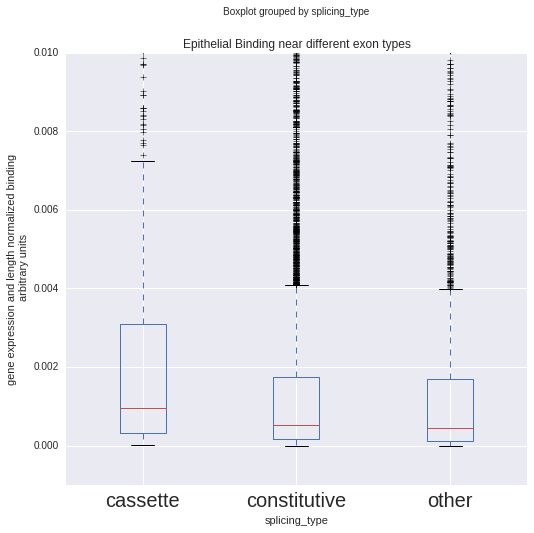

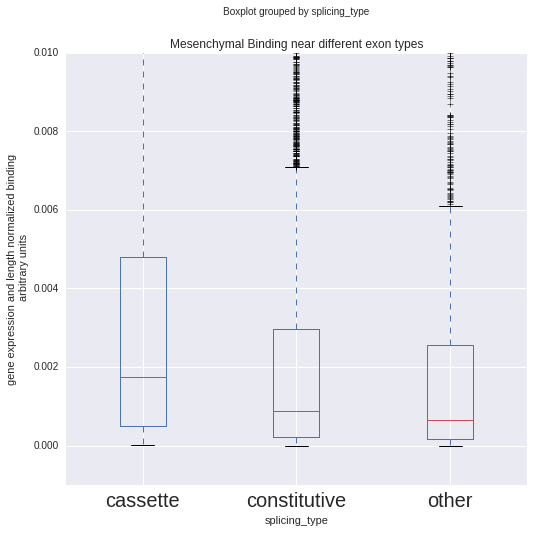

In [39]:
#Boxplots of binding
fig = dmso.boxplot(by='splicing_type',column='hnM_DMSO_clip_fpkm_length_norm',fontsize=20,figsize=(8,8))
fig.set_ylim(top=0.01,bottom=-0.001)
fig.set_title('Epithelial Binding near different exon types')
fig.set_ylabel('gene expression and length normalized binding\n arbitrary units')
values_per_group = [col for col_name, col in dmso.groupby(by='splicing_type')['hnM_DMSO_clip_fpkm_length_norm']]
print('Epithelial Wilcoxon Cassette to Constitutive',ss.ranksums(values_per_group[0],values_per_group[1]))

fig = tam.boxplot(by='splicing_type',column='hnM_TAM_clip_fpkm_length_norm',fontsize=20,figsize=(8,8))
fig.set_ylim(top=0.01,bottom=-0.001)
fig.set_title('Mesenchymal Binding near different exon types')
fig.set_ylabel('gene expression and length normalized binding\n arbitrary units')
values_per_group = [col for col_name, col in dmso.groupby(by='splicing_type')['hnM_TAM_clip_fpkm_length_norm']]
print('Mesenchymal Wilcoxon Cassette to Constitutive',ss.ranksums(values_per_group[0],values_per_group[1]))

In [41]:
#How many exons are showing up?
print(len(hg19_v19_exons_labeled_df))
print(len(hg19_v19_exons_labeled_bt_sorted_clip_slop_intersect_grouped))
print(len(intersect_df))
print(len(intersect_df_protein_coding))

324422
17493
17493
16022


In [116]:
intersect_df.loc[intersect_df.external_gene_name == 'APLP2']

,chrom,start,end,ens_gene,exon_id,strand,external_gene_name,biotype,alternative,splicing_type,hnM_DMSO_clip_fpkm_norm,hnM_TAM_clip_fpkm_norm
4572,chr11,129939963,129941142,ENSG00000084234,exon_61155,+,APLP2,protein_coding,yes,other,0.116208,0.056888
4575,chr11,129970765,129971908,ENSG00000084234,exon_61163,+,APLP2,protein_coding,yes,cassette,0.032538,0.000000
4576,chr11,129971321,129972395,ENSG00000084234,exon_61164,+,APLP2,protein_coding,yes,cassette,0.088318,0.000000
4577,chr11,129979933,129981056,ENSG00000084234,exon_61167,+,APLP2,protein_coding,yes,cassette,0.074373,0.000000
4578,chr11,129993007,129994174,ENSG00000084234,exon_61171,+,APLP2,protein_coding,yes,cassette,0.901773,0.268189
4579,chr11,130003024,130004123,ENSG00000084234,exon_61176,+,APLP2,protein_coding,no,NaN,0.088318,0.032508
4580,chr11,130004958,130006110,ENSG00000084234,exon_61177,+,APLP2,protein_coding,no,NaN,0.051131,0.000000
4581,chr11,130006651,130007686,ENSG00000084234,exon_61178,+,APLP2,protein_coding,yes,cassette,0.023242,0.000000
4582,chr11,130008173,130010050,ENSG00000084234,exon_61179,+,APLP2,protein_coding,yes,other,3.542015,0.755804
4583,chr11,130009793,130010878,ENSG00000084234,exon_61180,+,APLP2,protein_coding,yes,other,0.074373,0.000000


In [ ]:
#Old way I tried this


#NOTE - THIS IS NOT THE BEST WAY TO WORK ON THIS... BETTER TO DO AN EXON CENTRIC OR SPLICING EVENT CENTRIC ANALYSIS

#NOW FIGURE OUT HOW TO BRING IN THE ALTERNATIVE EXONS
#put this in the directory spliced_exon_analysis

#Goal - associate the clusters with nearest exon using bedtools closest

#Ideal setup - have each cluster associated with nearest 1 exon. This exon must be able to be labeled as constitutive vs. alternative. This exon must then be able to be associated with a PSI value from each of our RNA seq analyses... How can I do this? Many of the splicing events will not match exactly.

#Associate clusters with all exons first. Mark whether the exon is constitutive or variable.

#HOW CAN I KNOW WHETHER AN EXON IS CONSTITUTIVE OR ALTERNATIVE?
#WHY NOT USE RMATS FOR TWIST-ER CELLS? All SE called by rMATS will be merged and take the longest one. If an exon overlaps with this list, it is alternative. If it does not, it is constitutive
#Caveat with this - We don't want false positives. maxPSI > 15%, minPSI < 85% ensures we don't take all skipped or all included exons.
#Another source of information - MISO splicing library
#Another source = hg19 knownAlt
#If the exon is going to be paired with a PSI value it must be alternative

#Then associate clusters with alternative exons from rMATS. Presumably rMATS exons are all alternatively spliced and contain no constitutively spliced exons. Can separate significantly differentially spliced from control using Carsten's publication "control alternative" cutoff (FDR > 50%, maxPSI of > 15%, minPSI < 85%)

#As an exon annotation, I am using the hg19_v19 exons from CLIPPER, this is also copied in this directory
#Other exon annotations that are available:
#FAST-iCLIP-docs = hg19_transcriptome_collapse_exon.bed
#Extract transcript regions script
hg19_v19_exons = pd.read_csv('spliced_exon_analysis/hg19_v19_exons.bed',sep='\t',names=['chrom','start','stop','ens_gene','blank','strand'])
hg19_v19_exons['ens_gene']=hg19_v19_exons.ens_gene.str.split('.').str[0]
#read in gene names and biotypes
#I got this from ensembl biomart using the last GRCh37 archive - ENS version 75
hg19_grch37_gene_names_and_biotype = pd.read_csv('spliced_exon_analysis/ensembl_ens_gene_gene_name_biotype_grch37_p13',sep='\t',names=['ens_gene','external_gene_name','biotype'])
#why are there duplicates?
hg19_grch37_gene_names_and_biotype.drop_duplicates(inplace=True)

#merge the exons with the gene names and biotypes
hg19_v19_exons = pd.merge(hg19_v19_exons,hg19_grch37_gene_names_and_biotype,on='ens_gene',how='left')
hg19_v19_exons.to_csv('spliced_exon_analysis/hg19_v19_exon_gene_names_and_biotypes',sep='\t',header=False,index=False,na_rep='NaN')

#save a copy of the merge_df clusters as a bedtools
cluster_column_list = ['chrom','start','end','ens_gene','cluster_id','strand']
merge_df.to_csv('spliced_exon_analysis/merge_df.bed',sep='\t',na_rep='NaN',columns=cluster_column_list,header=False,index=False)

#run closest bed with exons and keep the distance as a column
#handle ties by taking both items
#This means that some of the clusters will be associated with multiple exons
!bedtools closest -a spliced_exon_analysis/merge_df.bed -b spliced_exon_analysis/hg19_v19_exon_gene_names_and_biotypes -D "ref" -s -t "all" > spliced_exon_analysis/merge_df_closest_exons

!bedtools closest -a spliced_exon_analysis/merge_df.bed -b spliced_exon_analysis/hg19_v19_exon_gene_names_and_biotypes -D "ref" -s -t "first" > spliced_exon_analysis/merge_df_closest_exons_first_ties

#bring in the data from TwistER, CC, and HH rMATS into splicing analysis folder
#I used parse_rMATS_SE -fdr 0.05 -psi 0.1 -read 20
#NOTE - it may be better for me in the future to just read in the data and parse it myself however I'd like - do this later

#Should I do bedtools closest on each cluster next to an exon from CC, HH, TwistER? Set a limit of maximal distance

#bring in the data from TwistER, CC, and HH rMATS into splicing analysis folder
#I used parse_rMATS_SE -fdr 0.05 -psi 0.1 -read 20
#NOTE - it may be better for me in the future to just read in the data and parse it myself however I'd like - do this later
#Should I do bedtools closest on each cluster next to an exon from CC, HH, TwistER? Set a limit of maximal distance
cc1_cc2_rMATS_df = pd.read_csv('spliced_exon_analysis/CC-1_CC-2_rMATS_3_2_5_SE_ROT_FDR_0.05_dPSI_0.1_read_cutoff_20.txt',sep='\t')
cc3_cc4_rMATS_df = pd.read_csv('spliced_exon_analysis/CC-3_CC-4_rMATS_3_2_5_SE_ROT_FDR_0.05_dPSI_0.1_read_cutoff_20.txt',sep='\t')
hh5_hh6_rMATS_df = pd.read_csv('spliced_exon_analysis/HH-5_HH-6_rMATS_3_2_5_SE_ROT_FDR_0.05_dPSI_0.1_read_cutoff_20.txt',sep='\t')
twist_d0_d14_rMATS_df = pd.read_csv('spliced_exon_analysis/SEH-1_SEH-2_rMATS_3_2_5_SE_ROT_FDR_0.05_dPSI_0.1_read_cutoff_20.txt',sep='\t')

#Now that I have this, I want to do bedtools closest to see if this this good